In [1]:
%load_ext autoreload
%autoreload 2

import os, errno

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
from tqdm import tqdm
import pymc3 as pm

import matplotlib.pyplot as plt
%matplotlib inline

import glam as gb

In [2]:
np.random.seed(1)

In [3]:
def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

In [4]:
make_sure_path_exists('examples/example_1/figures/')
make_sure_path_exists('examples/example_1/results/in_sample/traces/')
make_sure_path_exists('examples/example_1/results/in_sample/model_comparison/')
make_sure_path_exists('examples/example_1/results/out_of_sample/traces/')
make_sure_path_exists('examples/example_1/results/out_of_sample/predictions/')

# Example 1: Explore individual gaze biases

The first example is based on a study by Thomas et al. (2019). Here, the authors study the association between gaze allocation and choice behaviour on the level of the individual. Particularly, the authors explore whether (1) an association between gaze and choice is present at the individual level and (2) the strength of this association varies between individuals.

## Simulating data

First, we simulate a dataset of 30 subjects, each performning 200 simple value-based choice trials. We assume that in each trial participants are asked to choose the item that they like most out of a set of four presented alternatives (similar to the task described in Towal, Moorman & Koch, 2013). While participants perform the task, their eye movements, choices and response times are measured. After completing all choice trials, participants further indicate their liking rating for each of the items presented in the choice task on a liking rating scale from 1 to 10 (with 10 indicating strong liking and 1 indicating little liking). The resulting datasets contains a liking value for each choice item in each trial, the participants' choice and response, as well as their aggregated gaze data (describing the fraction of trial time that they spent looking at each item in the choice set).

In [5]:
n_subjects = 30
subjects = np.arange(n_subjects)
n_trials = 200
n_items = 3

To simulate individuals' choice behaviour, we define a set of generating model parameters for each individual. We assume that these parameters are drawn independently for each subject from uniform distributions (with lower and upper bound; based on the parameter estimates obtained in Thomas et al., 2019):

* v ~ U(2e-5,2e-4) 
* $\sigma$ ~ U(0.002,0.02) 
* $\gamma$ ~ U(-1,0.5) 
* $\tau$ ~ U(0.5,5)

Importantly, we further assume that five subjects do not exhibit a gaze bias (i.e., that their choices are independent of the time that they spend looking at each item). To this end, we will set the $\gamma$ parameter for five randomly selected subjects to 1. We further also assume that individuals’ gaze is distributed randomly with respect to the values of the items in a choice set. 

In [6]:
np.random.seed(6)
# generating model parameters (taken from Thomas et al., 2019)
gen_v = np.array([0.000121, 6.3e-05, 7.3e-05, 7.8e-05, 6.3e-05, 4.3e-05, 2e-05, 6e-05, 0.000157, 6.2e-05, 7.3e-05, 0.000118, 6.3e-05, 6.2e-05, 0.00011, 2e-05, 5.7e-05, 3.9e-05, 0.000117, 6.6e-05, 3e-05, 6.7e-05, 4.9e-05, 4e-05, 2.2e-05, 5.41e-05, 9.3e-05, 6.4e-05, 4.1e-05, 8.9e-05])
gen_gamma = np.array([0.31, 0.3, 0.81, -0.17, 0.65, -0.26, 0.34, -1.03, 0.31, -0.07, 0.48, 0.01, 0.41, 0.37, 0.52, 0.32, 0.3, 0.63, 0.2, 0.49, 0.38, -0.23, 0.07, 0.52, -0.42, -0.46, -0.03, 0.78, -0.07, -0.09])
gen_sigma = np.array([0.007088, 0.008777, 0.008888, 0.008498, 0.00661, 0.007155, 0.00695, 0.008606, 0.005291, 0.007948, 0.007924, 0.007294, 0.007428, 0.007635, 0.00514, 0.006489, 0.01144, 0.005515, 0.008126, 0.00999, 0.009338, 0.008122, 0.007445, 0.009055, 0.006532, 0.010194, 0.006534, 0.008277, 0.007029, 0.006392])
gen_tau = np.array([0.33, 0.55, 0.65, 0.98, 0.47, 1.39, 0.95, 0.83, 0.24, 1.2, 0.75, 0.32, 0.66, 1.02, 0.22, 1.37, 0.73, 1.55, 0.34, 0.29, 4.82, 0.47, 0.46, 0.78, 1.14, 1.52, 0.44, 0.78, 1.3, 0.48])
gen_t0 = np.zeros(n_subjects)
gen_gamma = np.random.uniform(-1, 0.5, n_subjects)
# define subjects with no association between gaze and choice:
no_gaze_bias_subjects = np.sort(np.random.choice(n_subjects, 5, replace=False))
gaze_bias_subjects = np.array([s for s in subjects if s not in no_gaze_bias_subjects])
gen_gamma[no_gaze_bias_subjects] = 1

# create a dictionary containing all generating parameters
gen_parameters = dict(v=gen_v,
                      gamma=gen_gamma,
                      s=gen_sigma,
                      t0=gen_t0,
                      tau=gen_tau)

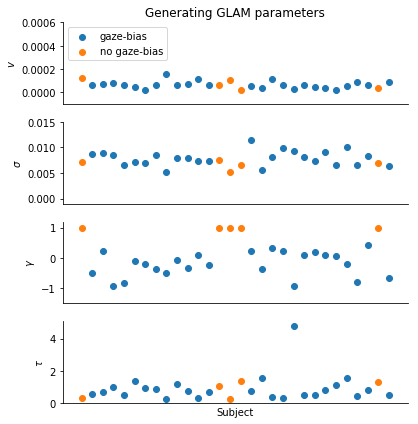

In [7]:
# overview of the distribution of generating parameters

fig, axs = plt.subplots(4, 1, figsize=(6,6), sharex=True)

for subject_set, color, label in zip([gaze_bias_subjects,
                                      no_gaze_bias_subjects],
                                      ['C0', 'C1'],
                                      ['gaze-bias', 'no gaze-bias']):
    # v
    axs[0].scatter(subject_set,
                   gen_v[subject_set],
                   label=label,
                   color=color)
    axs[0].set_ylabel(r'$v$')
    axs[0].set_xticks([])
    
    # sigma
    axs[1].scatter(subject_set,
                   gen_sigma[subject_set],
                   color=color)
    axs[1].set_ylabel(r'$\sigma$')
    axs[1].set_xticks([])

    # gamma
    axs[2].scatter(subject_set,
                   gen_gamma[subject_set],
                   color=color)
    axs[2].set_ylabel(r'$\gamma$')
    axs[2].set_xticks([])

    # tau
    axs[3].scatter(subject_set,
                   gen_tau[subject_set],
                   color=color)
    axs[3].set_ylabel(r'$\tau$')
    axs[3].set_xlabel('Subject')
    axs[3].set_xticks([])

axs[0].set_title('Generating GLAM parameters')
axs[0].set_ylim(-0.0001, 0.0006)
axs[1].set_ylim(-0.001, 0.015)
axs[2].set_ylim(-1.5, 1.2)
axs[3].set_ylim(0, 5.1)
axs[0].legend(loc='upper left')
for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
fig.tight_layout()
fig.savefig('examples/example_1/figures/Supplementary_Figure_1_generating_parameters.png', dpi=330)

Subjects with no association of gaze allocation and choice behaviour:

In [8]:
no_gaze_bias_subjects

array([ 0, 13, 14, 15, 28])

To simulate individuals' response behaviour, we use the *simulate_group* method of the GLAM model class. This function requires us to specify whether the individuals of this group are either simulated as individuals (and thereby independent of one another) or as part of a hierarchical parameter distribution (where the individual model parameters are drawn from a group distribution). If we specify the group as individual, the generating parameters need to be provided as a dictionary, containing one entry per parameter, containing an array of parameter values. 

In [9]:
np.random.seed(11)
glam = gb.GLAM() # create GLAM model instance
glam.simulate_group(kind='individual',
                    n_individuals=n_subjects,
                    n_trials=n_trials,
                    n_items=n_items,
                    parameters=gen_parameters,
                    value_range=(1, 10))

We can then access the simulated data as part of our glam model instance.

In [10]:
data = glam.data.copy()

In [11]:
data.head()

,subject,trial,repeat,choice,rt,item_value_0,gaze_0,item_value_1,gaze_1,item_value_2,gaze_2,condition
0,0.0,0.0,0.0,2.0,772.0,1,0.455900,2,0.456205,8,0.087895,condition_0
1,0.0,1.0,0.0,1.0,920.0,2,0.259137,8,0.379235,3,0.361629,condition_0
2,0.0,2.0,0.0,0.0,589.0,9,0.190054,1,0.058247,1,0.751699,condition_0
3,0.0,3.0,0.0,0.0,1327.0,5,0.100674,3,0.308233,2,0.591092,condition_0
4,0.0,4.0,0.0,2.0,1136.0,6,0.362027,6,0.215720,8,0.422253,condition_0


As this example is focussed on the individual level, we further create a summary dataframe, describing individuals' response behaviour on three behavioural metrics (as described in Thomas et al., 2019). Namely, individuals' mean response time, probability of choosing the item with the highest liking rating from a choice set and a behavioural measure of the strength of the association between gaze allocation and choice behaviour (indicating the mean increase in choice probability for an item that was looked at longer than the others, after correcting for the inﬂuence of item value on choice probability; for further details on the behavioural gaze bias measure, see Thomas et al., 2019).

In [12]:
subject_data_summary = gb.analysis.aggregate_subject_level_data(data, n_items)

In [13]:
subject_data_summary.head()

rt                                                          \
             mean         std    min     max         se       q1       q3   
subject                                                                     
0.0      1253.730  513.545837  589.0  4871.0  36.404299   978.00  1368.50   
1.0      2061.860  750.329081  207.0  4624.0  53.189418  1522.00  2464.50   
2.0      1740.675  635.312332  591.0  4703.0  45.036097  1269.75  2062.75   
3.0      1612.650  633.136524  524.0  4349.0  44.881858  1167.75  1872.75   
4.0      2245.865  753.740245  519.0  5214.0  53.431229  1744.50  2697.00   

               best_chosen gaze_influence  
           iqr        mean                 
subject                                    
0.0      390.5       0.900      -0.039730  
1.0      942.5       0.370       0.429390  
2.0      793.0       0.695       0.266009  
3.0      705.0       0.310       0.555046  
4.0      952.5       0.340       0.492550

## Explore behavioural data 

In a first step of our analysis, we explore differences in individuals' response behaviour on these three behavioural metrics. To create an overview of the distribution of individuals' values on the metrics, as well as the associations between them, we make use of the *individual_differences* function implemented in the GLAMbox plots module.

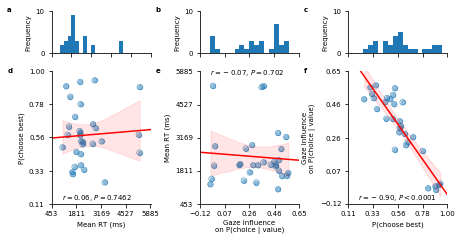

In [14]:
fig = gb.plots.individual_differences(data=data,
                                      regression=True,
                                      annotate=True)
fig.savefig('examples/example_1/figures/Figure_1_individual_differences.png', dpi=330)

We find that most individuals exhibit a positive association of gaze allocation and choice behaviour, as indicated by the behavioural gaze bias measure (b).

Further, we find that both, individuals' probability of choosing the best item and behavioural gaze bias, are not associated with their respose times. Interestingly, however, individuals' probability of choosing the best item from a choice set increases with decreasing strength of the behavioural gaze bias. Individuals with a strong association of gaze allocation and choice behaviour (as indicated by high values on the behavioural gaze bias measure) are therefore less likely to choose the item with the highest value from a choice set, when compared to individuals with a weak association of gaze and choice.

## Individual Model Comparison

### Relative Model Fit

In a second step of our analysis, we want to test whether the response behaviour of each individual in the data is better described by a GLAM variant with or without gaze bias (i.e., a variant in which the gaze bias parameter is fixed to 1). To this end, we set up both model instances:

In [15]:
np.random.seed(25)
glam_bias = gb.GLAM(data=data)
glam_bias.make_model(kind='individual')

glam_nobias = gb.GLAM(data=data)
glam_nobias.make_model(kind='individual', gamma_val=1)

Generating single subject models for 30 subjects...
Generating single subject models for 30 subjects...


Subsequently, we fit both of model variants to the data of each individual and compare their fit by means of the Widely Applicable Information Criterion (WAIC; Vehtari, Gelman, & Gabry, 2017). To fit each model, we utilize an MCMC sampling procedure with the Metropolis-Hastings algorithm (XXX). For each model and parameter, we sample four chains. Each chain contains 10000 tuning samples (that we discard) and another 10000 samples that we use to determine individuals' parameter estimates. All resulting parameter traces were checked for convergence, before performing the model comparison. We establish convergence for a trace if the Rhat measure (XXX) is between 0.95 and 1.05 or the trace contains at least 100 effective samples (XXX). All parameter traces were further check for convergence by visual inspection.

In [16]:
glam_bias.fit(method='MCMC',
              tune=20000,
              draws=5000,
              chains=4)

Fitting 30 model(s) using MCMC...
  Fitting model 1 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [02:13<00:00, 749.92draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 2 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [02:09<00:00, 772.49draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 3 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [02:09<00:00, 774.31draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 4 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [02:11<00:00, 758.04draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 5 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [02:09<00:00, 770.00draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 6 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [02:09<00:00, 773.12draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 7 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [02:07<00:00, 785.18draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 8 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [02:07<00:00, 785.57draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 9 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [02:05<00:00, 798.85draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 10 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [02:00<00:00, 829.05draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 11 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:54<00:00, 874.29draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 12 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:56<00:00, 860.69draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 13 of 30...


INFO (theano.gof.compilelock): Waiting for existing lock by process '10721' (I am process '13535')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/felixmolter/.theano/compiledir_Darwin-18.6.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '10721' (I am process '13535')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/felixmolter/.theano/compiledir_Darwin-18.6.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '10721' (I am process '13535')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/felixmolter/.theano/compiledir_Darwin-18.6.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '10721' (I am process '13535')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/felixmolter/.theano/compiledir_Darwin-18.6.0-x

  Fitting model 14 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:55<00:00, 863.90draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 15 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:53<00:00, 881.49draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 16 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:55<00:00, 867.21draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 17 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:49<00:00, 910.36draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 18 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:49<00:00, 914.87draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 19 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:50<00:00, 901.20draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 20 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:48<00:00, 920.40draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 21 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:46<00:00, 939.32draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 22 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:45<00:00, 947.05draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 23 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:42<00:00, 973.83draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 24 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:42<00:00, 972.32draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 25 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:42<00:00, 979.51draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 26 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:39<00:00, 1002.20draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 27 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:43<00:00, 968.65draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 28 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:41<00:00, 985.11draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 29 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:45<00:00, 946.12draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 30 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:43<00:00, 963.37draws/s]
The number of effective samples is smaller than 10% for some parameters.


/!\ Automatically setting parameter precision...


In [17]:
glam_nobias.fit(method='MCMC',
                tune=20000,
                draws=5000,
                chains=4)

Fitting 30 model(s) using MCMC...
  Fitting model 1 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:07<00:00, 1477.53draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 2 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:04<00:00, 1542.02draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 3 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:04<00:00, 1542.56draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 4 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:02<00:00, 1608.19draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 5 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:03<00:00, 1566.00draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 6 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:58<00:00, 1708.65draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 7 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:58<00:00, 1711.74draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 8 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:56<00:00, 1759.71draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 9 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:58<00:00, 1722.27draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 10 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:03<00:00, 1565.70draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 11 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:06<00:00, 1495.57draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 12 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:03<00:00, 1584.09draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 13 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:02<00:00, 1594.18draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 14 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:03<00:00, 1571.71draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 15 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:01<00:00, 1617.83draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 16 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:02<00:00, 1604.30draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 17 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:03<00:00, 1580.93draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 18 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:02<00:00, 1602.36draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 19 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:03<00:00, 1570.86draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 20 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:01<00:00, 1628.04draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 21 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:01<00:00, 1626.49draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 22 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:07<00:00, 1480.35draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 23 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:01<00:00, 1617.80draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 24 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:58<00:00, 1699.47draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 25 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:01<00:00, 1635.01draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 26 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:01<00:00, 1626.39draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 27 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:00<00:00, 1645.67draws/s]
The number of effective samples is smaller than 25% for some parameters.


  Fitting model 28 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:03<00:00, 1566.18draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 29 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:01<00:00, 1632.70draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 30 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:58<00:00, 1720.24draws/s]
The number of effective samples is smaller than 10% for some parameters.


/!\ Automatically setting parameter precision...


Convergence check:

In [18]:
def check_convergence(summary, varnames=['v', 's', 'tau'],
                      n_eff_required=100, gelman_rubin_criterion=0.05):
    varnames = [varname + '__0_0' for varname in varnames]
    enough_eff_samples = np.all(summary.loc[varnames]['n_eff'] > n_eff_required)
    good_gelman = np.all(np.abs(summary.loc[varnames]['Rhat'] - 1.0) < gelman_rubin_criterion)
    if not enough_eff_samples or not good_gelman:
        return False
    else:
        return True

In [19]:
np.all([check_convergence(pm.summary(trace), varnames=['v', 's', 'gamma', 'tau']) for trace in glam_bias.trace])

True

In [20]:
np.all([check_convergence(pm.summary(trace), varnames=['v', 's', 'tau']) for trace in glam_nobias.trace])

True

Saving traces and traceplots for visual inspection:

In [21]:
import pymc3 as pm

In [22]:
for subject, subject_trace in enumerate(glam_bias.trace):
#     pm.traceplot(subject_trace)
#     plt.savefig('examples/example_1/results/in_sample/traces/sub_{}_gaze_bias_model_trace.png'.format(subject), dpi=330)
    plt.close()
    pm.trace_to_dataframe(subject_trace).to_csv(
        'examples/example_1/results/in_sample/traces/sub_{}_gaze_bias_model_trace.csv'.format(subject))

In [23]:
for subject, subject_trace in enumerate(glam_nobias.trace):
#     pm.traceplot(subject_trace)
#     plt.savefig('examples/example_1/results/in_sample/traces/sub_{}_no_gaze_bias_model_trace.png'.format(subject), dpi=330)
    plt.close()
    pm.trace_to_dataframe(subject_trace).to_csv(
        'examples/example_1/results/in_sample/traces/sub_{}_no_gaze_bias_model_trace.csv'.format(subject))

After convergence has been established for each trace, we can perform a model comparison on the individual level. For this comparison, we utilize the *compare* function of the PyMC3 library.

In [24]:
dWAIC = np.array([])
for subject in tqdm(subjects):
    waic_df = pm.compare({glam_bias.model[subject]: glam_bias.trace[subject],
                          glam_nobias.model[subject]: glam_nobias.trace[subject]},
                          ic='WAIC') 
    # pm.compare indexes models in waic_df by the order in which they were entered
    # we entered the model with gaze bias first, it therefore has index 0 in waic_df
    if waic_df.index.values[0] == 0:
        # model with gaze bias is best fitting
        dWAIC = np.append(dWAIC, -1 * waic_df.loc[1, 'dWAIC'])
    else:
        # model without gaze bias is best fitting
        dWAIC = np.append(dWAIC, waic_df.loc[0, 'dWAIC'])
np.save('examples/example_1/results/in_sample/model_comparison/dWAIC_in_sample.npy', dWAIC)

100%|██████████| 30/30 [09:20<00:00, 18.74s/it]


In [25]:
# identify subjects better described by each model variant
gaze_bias_idx = dWAIC < 0
no_gaze_bias_idx = dWAIC > 0

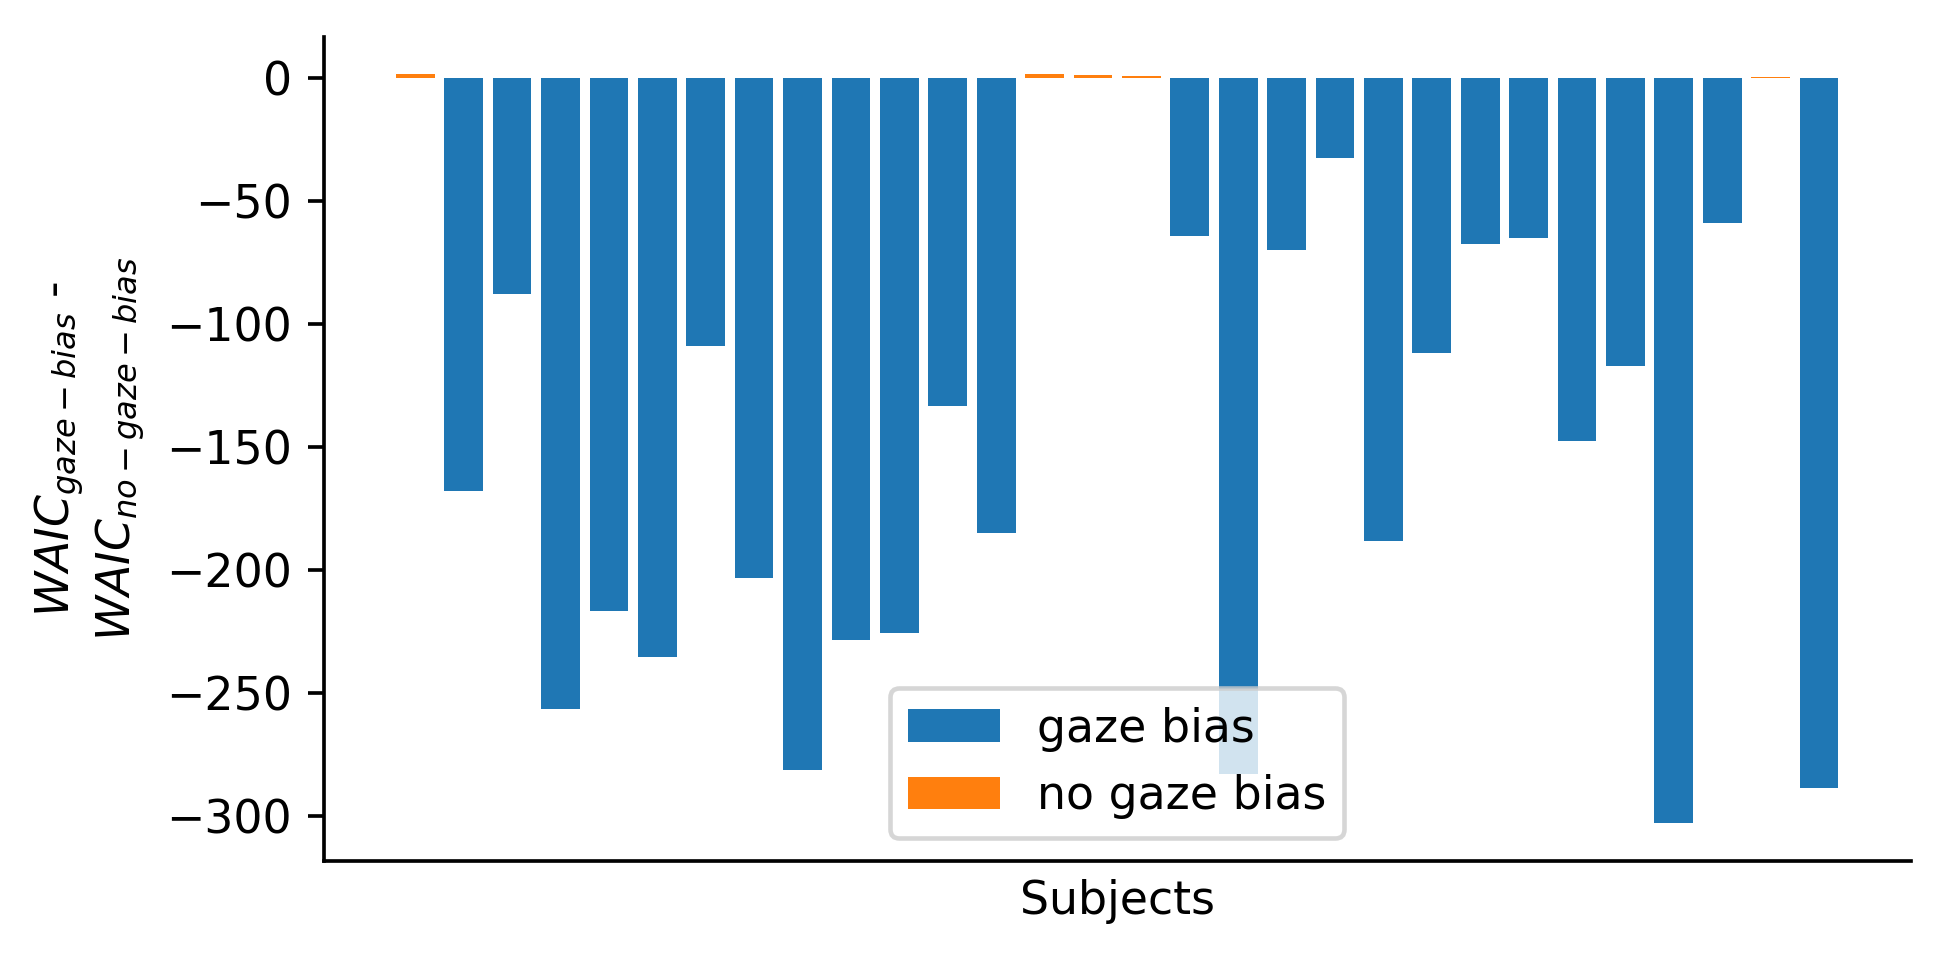

In [26]:
fig, ax = plt.subplots(1,1,figsize=(6,3),dpi=330)

ax.bar(subjects[gaze_bias_idx], dWAIC[gaze_bias_idx], color='C0', label='gaze bias')
ax.bar(subjects[no_gaze_bias_idx], dWAIC[no_gaze_bias_idx], color='C1', label='no gaze bias')
ax.set_xlabel('Subjects')
ax.set_ylabel(r'$WAIC_{gaze-bias}$'+' -\n'+r'$WAIC_{no-gaze-bias}$')
ax.legend()
ax.set_xticks([])
ax.tick_params(axis='both', which='major')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()

fig.savefig('examples/example_1/figures/Figure_1_relative_model_comparison.png', dpi=330)

We find that all subjects, except for those which we defined as not having a gaze bias, are better described by a GLAM variant with gaze bias than by one without (as indicated by a lower WAIC score). 

In [27]:
subjects[no_gaze_bias_idx]

array([ 0, 13, 14, 15, 28])

When looking at the individual parameter estimates (defined as maximum-a-priori or MAP of the GLAM's posterior traces), we find that the individually fitted $\gamma$ values (see Fig. XX) cover a wide range between XX and XX. We also find that $\gamma$ estimates are strongly correlated with individuals’ values on the behavioural gaze bias measure (see Fig. XX). Thereby, indicating that the strength of the association between individuals’ gaze allocation and choice behaviour strongly varies between individuals. 

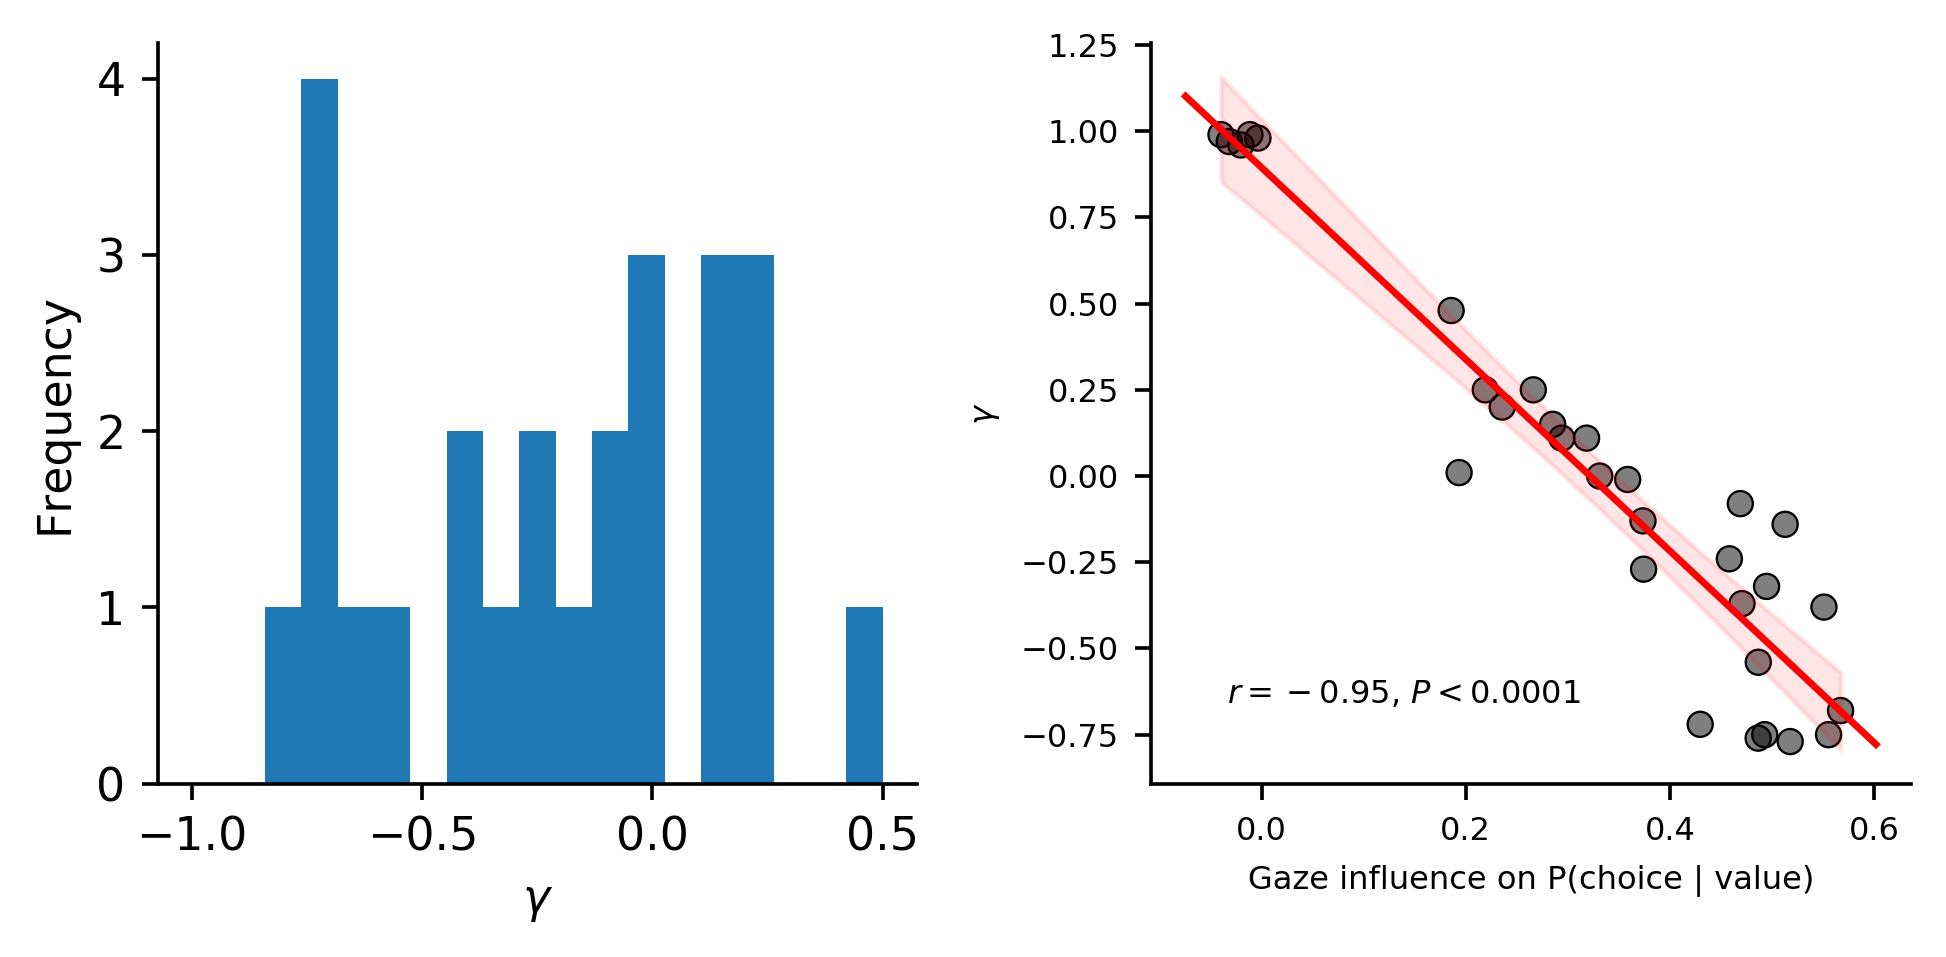

In [28]:
fig, axs = plt.subplots(1,2,figsize=(6,3),dpi=330)

axs[0].hist(glam_bias.estimates['gamma'],
            bins=np.linspace(-1,0.5,20))
gb.plots.plot_correlation(subject_data_summary['gaze_influence'],
                          glam_bias.estimates['gamma'],
                          ax=axs[1])

axs[0].set_ylabel('Frequency')
axs[0].set_xlabel(r'$\gamma$')
axs[1].set_ylabel(r'$\gamma$')
axs[1].set_xlabel('Gaze influence on P(choice | value)')
fig.tight_layout()
fig.savefig('examples/example_1/figures/Figure_2_gaze_bias_estimates.png', dpi=330)

### Absolute Model Fit

Our likelihood-based model comparison has indiciated whether the response behaviour of each individual in the data is better described by a GLAM variant with or without gaze bias. Yet, it did not indicate whether the GLAM also represents a good model of their response behaviour on an absolute level. To test this, we further perform an out-of-sample prediction exersice.

First, we divide the data of each subject into the even- and odd-numbered experiment trials:

In [29]:
data_even = data[(data['trial']%2)==0].copy()
data_odd = data[(data['trial']%2)!=0].copy()

In [30]:
glam_bias.exchange_data(data_even)
glam_bias.fit(method='MCMC',
              tune=20000,
              draws=5000,
              chains=4)

glam_nobias.exchange_data(data_even)
glam_nobias.fit(method='MCMC',
                tune=20000,
                draws=5000,
                chains=4)

Replaced attached data (6000 trials) with new data (3000 trials)...
Fitting 30 model(s) using MCMC...
  Fitting model 1 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:31<00:00, 1092.37draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 2 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:30<00:00, 1099.77draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 3 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:32<00:00, 1080.73draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 4 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:32<00:00, 1075.36draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 5 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:32<00:00, 1085.00draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 6 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:30<00:00, 1108.36draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 7 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:30<00:00, 1100.97draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 8 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:32<00:00, 1081.21draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 9 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:33<00:00, 1071.29draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 10 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:32<00:00, 1075.68draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 11 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:30<00:00, 1104.67draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 12 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:28<00:00, 1125.17draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 13 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:27<00:00, 1149.20draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 14 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:25<00:00, 1174.93draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 15 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:25<00:00, 1171.29draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 16 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:26<00:00, 1155.47draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 17 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:25<00:00, 1168.42draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 18 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:29<00:00, 1119.99draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 19 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:26<00:00, 1154.13draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 20 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:26<00:00, 1150.62draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 21 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:28<00:00, 1131.33draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 22 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:26<00:00, 1152.31draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 23 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:26<00:00, 1159.07draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 24 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:27<00:00, 1145.10draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 25 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:26<00:00, 1159.05draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 26 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:26<00:00, 1155.66draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 27 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:26<00:00, 1156.83draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 28 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:26<00:00, 1160.55draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 29 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:26<00:00, 1156.09draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 30 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:26<00:00, 1156.65draws/s]
The number of effective samples is smaller than 10% for some parameters.


/!\ Automatically setting parameter precision...
Replaced attached data (6000 trials) with new data (3000 trials)...
Fitting 30 model(s) using MCMC...
  Fitting model 1 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:00<00:00, 1656.93draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 2 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:57<00:00, 1735.30draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 3 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:57<00:00, 1730.91draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 4 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:57<00:00, 1747.21draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 5 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:57<00:00, 1725.41draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 6 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:58<00:00, 1714.50draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 7 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:57<00:00, 1746.79draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 8 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:57<00:00, 1726.74draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 9 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:57<00:00, 1733.73draws/s]
The number of effective samples is smaller than 25% for some parameters.


  Fitting model 10 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:58<00:00, 1720.94draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 11 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:57<00:00, 1732.26draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 12 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:57<00:00, 1730.73draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 13 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:57<00:00, 1747.59draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 14 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:58<00:00, 1722.22draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 15 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:57<00:00, 1744.37draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 16 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:53<00:00, 1878.59draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 17 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:51<00:00, 1931.08draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 18 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:51<00:00, 1302.26draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 19 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:55<00:00, 1812.11draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 20 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:52<00:00, 1903.11draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 21 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:51<00:00, 1924.91draws/s]
The number of effective samples is smaller than 25% for some parameters.


  Fitting model 22 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:52<00:00, 1915.01draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 23 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:48<00:00, 2052.71draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 24 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:48<00:00, 2044.35draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 25 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:49<00:00, 2017.60draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 26 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:50<00:00, 1980.86draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 27 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:50<00:00, 1972.69draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 28 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:49<00:00, 2010.07draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 29 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:49<00:00, 2033.48draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 30 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 100000/100000 [01:07<00:00, 1479.02draws/s]
The number of effective samples is smaller than 10% for some parameters.


/!\ Automatically setting parameter precision...


##### old version

We then use the data of the even-numbered trials to fit both GLAM variants:

##### old version end

Again, we check all parameter traces for convergence, before preceeding further in the anlaysis:

In [31]:
np.all([check_convergence(pm.summary(trace), varnames=['v', 's', 'gamma', 'tau'])
        for trace in glam_bias.trace])

True

In [32]:
np.all([check_convergence(pm.summary(trace), varnames=['v', 's', 'tau'])
        for trace in glam_nobias.trace])

True

In [33]:
for subject, subject_trace in enumerate(glam_bias.trace):
#     pm.traceplot(subject_trace)
#     plt.savefig('examples/example_1/results/out_of_sample/traces/sub_{}_gaze_bias_model_trace.png'.format(subject), dpi=330)
    plt.close()
    pm.trace_to_dataframe(subject_trace).to_csv(
        'examples/example_1/results/out_of_sample/traces/sub_{}_gaze_bias_model_trace.csv'.format(subject))

In [34]:
for subject, subject_trace in enumerate(glam_nobias.trace):
#     pm.traceplot(subject_trace)
#     plt.savefig('examples/example_1/figures/traceplots/out_of_sample/sub_{}_no_gaze_bias_model_trace.png'.format(subject), dpi=330)
    plt.close()
    pm.trace_to_dataframe(subject_trace).to_csv(
        'examples/example_1/results/out_of_sample/traces/sub_{}_no_gaze_bias_model_trace.csv'.format(subject))

After establishing convergence of all parameter traces, we utilize the individually estimated models to predict choices and response times for each trial in the held-out dataset (containing all odd-numbered experiment trials). In this simulation, we repeat each trial 50 times in order to gain a stable estimate of the GLAM's response behaviour:

In [35]:
n_repeats = 50

In [36]:
glam_bias.exchange_data(data_odd)
glam_bias.predict(n_repeats=50)

glam_nobias.exchange_data(data_odd)
glam_nobias.predict(n_repeats=50)

  0%|          | 0/3000 [00:00<?, ?it/s]

Replaced attached data (3000 trials) with new data (3000 trials)...
Generating predictions for 3000 trials (50 repeats each)...


  0%|          | 0/3000 [00:00<?, ?it/s]

Replaced attached data (3000 trials) with new data (3000 trials)...
Generating predictions for 3000 trials (50 repeats each)...


100%|██████████| 3000/3000 [54:31<00:00,  1.51s/it]


In [37]:
glam_bias.prediction.to_csv('examples/example_1/results/out_of_sample/predictions/gaze_bias_model_predictions.csv')
glam_nobias.prediction.to_csv('examples/example_1/results/out_of_sample/predictions/no_gaze_bias_model_predictions.csv')

Again, we aggregate the predictions of both model variants on the individual level by the use of the *aggregate_subject_level_data* function:

In [38]:
glam_bias_pred_subject_summary = gb.analysis.aggregate_subject_level_data(glam_bias.prediction, n_items)
print(glam_bias_pred_subject_summary.head())

                rt                                                         \
              mean         std    min     max        se       q1       q3   
subject                                                                     
0.0      1257.9446  512.223408  524.0  4867.0  7.244657   991.00  1379.00   
1.0      1926.5768  667.324580  549.0  5876.0  9.438339  1446.75  2297.00   
2.0      1741.4088  646.275719  572.0  4844.0  9.140633  1292.00  2039.25   
3.0      1520.8658  598.659894  428.0  4339.0  8.467176  1106.75  1797.00   
4.0      2081.4612  699.024813  694.0  5211.0  9.886692  1578.75  2440.25   

                best_chosen gaze_influence  
            iqr        mean                 
subject                                     
0.0      388.00      0.8764      -0.000596  
1.0      850.25      0.3614       0.454177  
2.0      747.25      0.7114       0.269556  
3.0      690.25      0.4170       0.508053  
4.0      861.50      0.3632       0.496942  


In [39]:
glam_nobias_pred_subject_summary = gb.analysis.aggregate_subject_level_data(glam_nobias.prediction, n_items)
print(glam_nobias_pred_subject_summary.head())

                rt                                                         \
              mean         std    min     max         se       q1      q3   
subject                                                                     
0.0      1286.9630  550.417675  488.0  4858.0   7.784860  1002.00  1413.0   
1.0      2044.7320  699.076468  529.0  7243.0   9.887423  1536.00  2431.0   
2.0      1752.6550  649.641299  462.0  4813.0   9.188234  1295.75  2068.0   
3.0      1597.2362  602.892435  474.0  5629.0   8.527039  1167.00  1895.0   
4.0      2254.6264  727.767972  760.0  5488.0  10.293223  1734.00  2661.0   

                best_chosen gaze_influence  
            iqr        mean                 
subject                                     
0.0      411.00      0.8766       0.002587  
1.0      895.00      0.3662      -0.004067  
2.0      772.25      0.7042       0.006196  
3.0      728.00      0.3838      -0.000805  
4.0      927.00      0.3908      -0.012569  


To then determine the absolute fit of both model variants to the data, we plot the individually predited against the individually observed data on our three behavioural metrics. To do this, we utilize the *absolute_fit_individual* function of the plots module. This function takes as input the subject-level summary of the observed data, as well as a list of the subject-level summaries of the predictions of all model variants that are to be compared. For each model variant, the function creates a new row of panels, plotting the observed against the predicted data.

AttributeError: 'tuple' object has no attribute 'startswith'

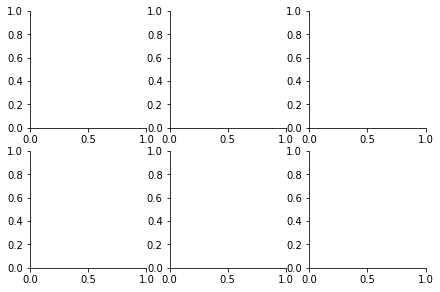

In [42]:
fig = gb.plots.plot_individual(observed=gb.analysis.aggregate_subject_level_data(data_odd, n_items),
                                       predictions=[glam_bias_pred_subject_summary,
                                                    glam_nobias_pred_subject_summary],
                                       prediction_labels=['gaze-bias', 'no gaze-bias'])
fig.savefig('examples/example_1/figures/Figure_3_absolute_fit.png', dpi=330)

Both model variants perform well in capturing individuals' response times and probability of choosing the best item. Yet, only the GLAM variant with gaze bias is able to also recover the strength of the association between individuals' choice behaviour and gaze allocation.

## Association between model parameters and behaviour

In the last step of our analysis, we want to test whether the individual GLAM parameter estimates from the even-numbered experiment trials are able to predict individuals' response characteristics on the three behavioural metrics in the odd-numbered trials. To this end, we plot each set of parameter against each behavioural metric.

### Gaze bias model

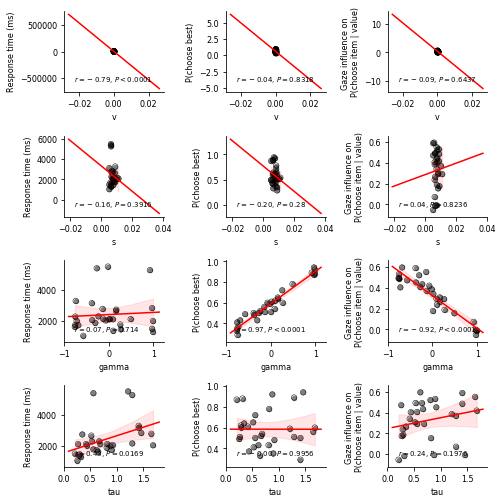

In [43]:
fig, axs = plt.subplots(4,3, figsize=gb.plots.cm2inch(18,18))


subject_data_summary_odd = gb.analysis.aggregate_subject_level_data(data_odd, n_items)
for i, parameter in enumerate(['v', 's', 'gamma', 'tau']): 
    
    # response time
    gb.plots.plot_correlation(glam_bias.estimates[parameter],
                              subject_data_summary_odd['rt']['mean'],
                              ax=axs[i,0])
    axs[i,0].set_xlabel(r'{}'.format(parameter), fontsize=8)
    axs[i,0].set_ylabel('Response time (ms)', fontsize=8)
    
    # P(choose item | value)
    gb.plots.plot_correlation(glam_bias.estimates[parameter],
                              subject_data_summary_odd['best_chosen']['mean'],
                              ax=axs[i,1])
    axs[i,1].set_xlabel(r'{}'.format(parameter), fontsize=8)
    axs[i,1].set_ylabel('P(choose best)', fontsize=8)
    
    # Gaze influence on P(choose item | value)
    gb.plots.plot_correlation(glam_bias.estimates[parameter],
                              subject_data_summary_odd['gaze_influence'],
                              ax=axs[i,2])
    axs[i,2].set_xlabel(r'{}'.format(parameter), fontsize=8)
    axs[i,2].set_ylabel('Gaze influence on \nP(choose item | value)', fontsize=8)
    
for ax in axs.ravel():
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=8)

fig.tight_layout()
fig.savefig('examples/example_1/figures/Figure_4_behaviour_paramater_correlations.png', dpi=330)

### No Bias model

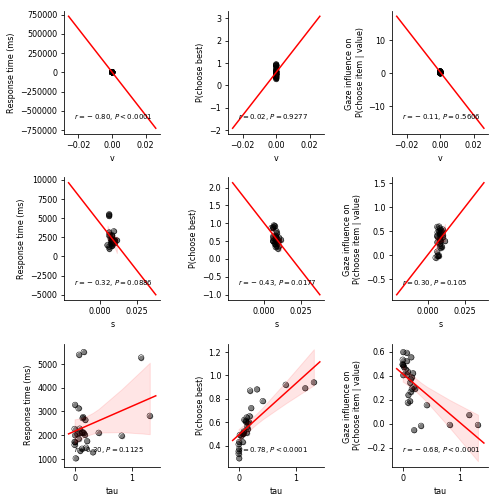

In [44]:
fig, axs = plt.subplots(3,3, figsize=gb.plots.cm2inch(18,18))


subject_data_summary_odd = gb.analysis.aggregate_subject_level_data(data_odd, n_items)
for i, parameter in enumerate(['v', 's', 'tau']): 
    
    # response time
    gb.plots.plot_correlation(glam_nobias.estimates[parameter],
                              subject_data_summary_odd['rt']['mean'],
                              ax=axs[i,0])
    axs[i,0].set_xlabel(r'{}'.format(parameter), fontsize=8)
    axs[i,0].set_ylabel('Response time (ms)', fontsize=8)
    
    # P(choose item | value)
    gb.plots.plot_correlation(glam_nobias.estimates[parameter],
                              subject_data_summary_odd['best_chosen']['mean'],
                              ax=axs[i,1])
    axs[i,1].set_xlabel(r'{}'.format(parameter), fontsize=8)
    axs[i,1].set_ylabel('P(choose best)', fontsize=8)
    
    # Gaze influence on P(choose item | value)
    gb.plots.plot_correlation(glam_nobias.estimates[parameter],
                              subject_data_summary_odd['gaze_influence'],
                              ax=axs[i,2])
    axs[i,2].set_xlabel(r'{}'.format(parameter), fontsize=8)
    axs[i,2].set_ylabel('Gaze influence on \nP(choose item | value)', fontsize=8)
    
for ax in axs.ravel():
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=8)

fig.tight_layout()
fig.savefig('examples/example_1/figures/Figure_4_behaviour_paramater_correlations.png', dpi=330)